In [148]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# import torch

# tensor = torch.tensor

In [149]:
# print(torch.cuda.is_available())
# print(torch.cuda.device_count())
# print(torch.cuda.current_device())
# print(torch.cuda.get_device_name(0))

In [150]:
# braess_beta = tensor([
#     [0,0,50,  torch.inf],
#     [0,0,torch.inf, 50],
#     [50,torch.inf, 0,0],
#     [torch.inf, 50,0 ,0]
# ])
# braess_alpha = tensor([
#     [0,10,1,  torch.inf],
#     [10,0,torch.inf, 1],
#     [1,torch.inf, 0,10],
#     [torch.inf, 1,10 ,0]
# ])

braess_beta = np.array(
    [
        [0, 50, 50, np.inf],
        [50, 0, np.inf, 50],
        [50, 10, 0, 50],
        [np.inf, 50, 50, 0],
    ]
)

braess_alpha = np.array(
    [[0, 10, 1, np.inf], [10, 0, np.inf, 1], [1, 1, 0, 10], [np.inf, 1, 10, 0]]
)
P = np.array([-6, 0, 0, 6])


braess_conectivity = 1 * braess_alpha + braess_beta


braess_conectivity_plot = braess_conectivity.copy()
braess_conectivity_plot[braess_conectivity_plot == np.inf] = 0
n = braess_conectivity.shape[0]
braess_conectivity

array([[ 0., 60., 51., inf],
       [60.,  0., inf, 51.],
       [51., 11.,  0., 60.],
       [inf, 51., 60.,  0.]])

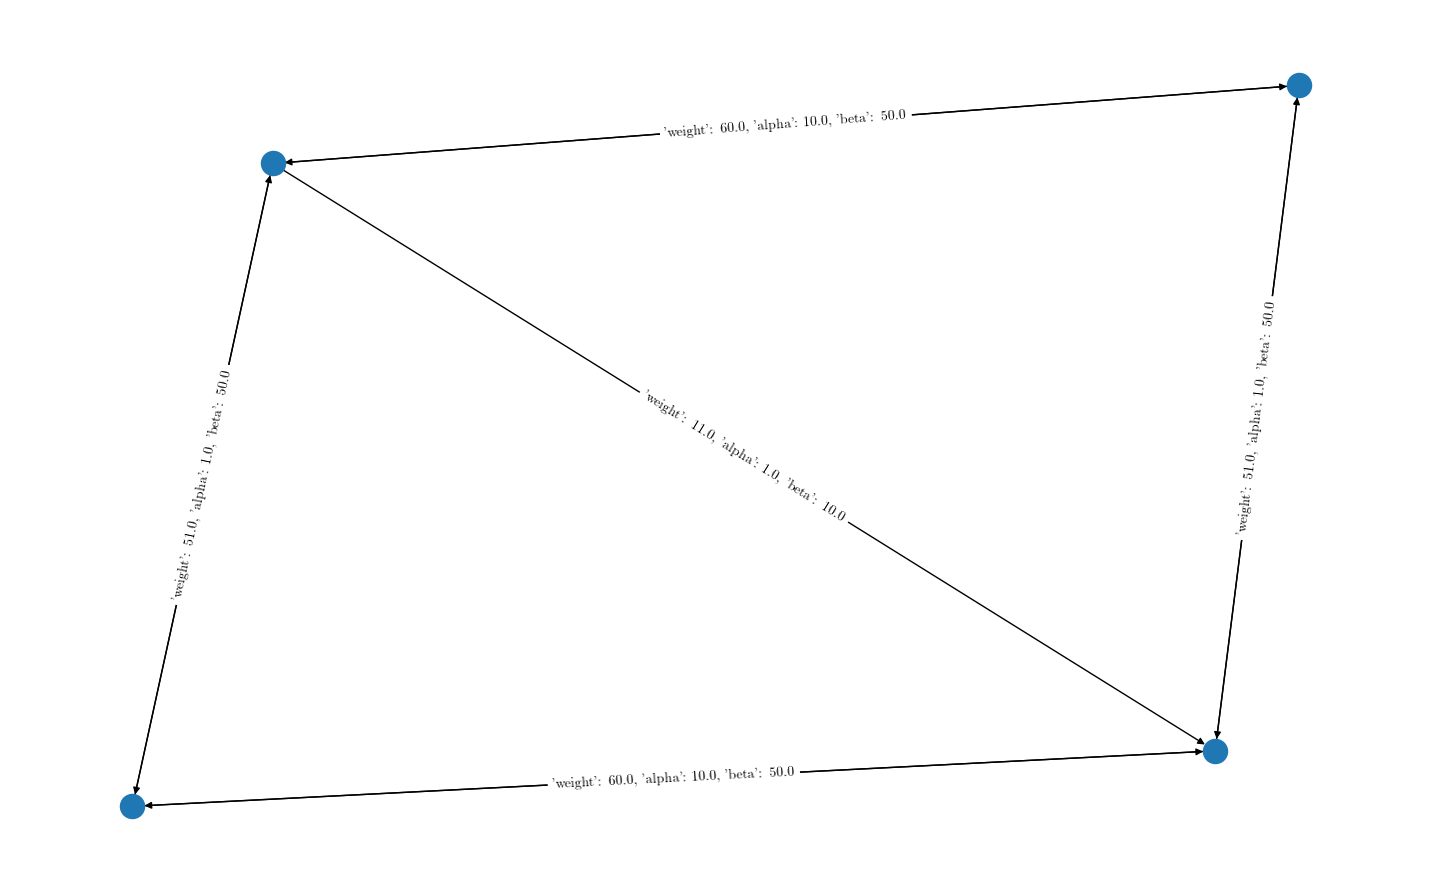

In [151]:
G = nx.from_numpy_array(braess_conectivity_plot, create_using=nx.DiGraph)
for e in G.edges:
    i, j = e
    G.edges[i, j]["alpha"] = float(braess_alpha[i, j])
    G.edges[i, j]["beta"] = float(braess_beta[i, j])


layout = nx.spring_layout(G)
nx.draw(G, layout)
nx.draw_networkx_edge_labels(G, pos=layout)
plt.show()

In [152]:
braess_conectivity

array([[ 0., 60., 51., inf],
       [60.,  0., inf, 51.],
       [51., 11.,  0., 60.],
       [inf, 51., 60.,  0.]])

In [153]:
res_mat = braess_conectivity.copy()
power = 3
for _ in range(power):
    res_mat_new = res_mat.copy()
    for i in range(n):
        for j in range(n):
            res_mat_new[i, j] = np.min(res_mat[i] + res_mat[:, j])
    res_mat = res_mat_new

res_mat

array([[  0.,  60.,  51., 111.],
       [ 60.,   0., 111.,  51.],
       [ 51.,  11.,   0.,  60.],
       [111.,  51.,  60.,   0.]])

In [154]:
braess_con_flow = braess_conectivity.copy()
braess_beta_flow = braess_beta.copy()
braess_alpha_flow = braess_alpha.copy()
for i in range(n):
    for j in range(n):
        if res_mat[-1, i] > res_mat[-1, j]:
            braess_con_flow[i, j] = np.inf
            braess_beta_flow[i, j] = np.inf
            braess_alpha_flow[i, j] = np.inf

In [155]:
braess_beta_flow

array([[ 0., inf, inf, inf],
       [50.,  0., inf, inf],
       [50., inf,  0., inf],
       [inf, 50., 50.,  0.]])

In [156]:
# L = 1/braess_alpha_flow
# L += 1/braess_alpha_flow.T
# L[torch.arange(n),torch.arange(n)] = 0
# L

L2 = -1 / braess_alpha_flow - 1 / braess_alpha_flow.T
L2[np.arange(n), np.arange(n)] = 0
L2[np.arange(n), np.arange(n)] = -L2.sum(-1)
L2

L2

/var/folders/c2/7dvwdvpn4xx3ch9f74c148400000gn/T/ipykernel_89495/4011364957.py:6: RuntimeWarning: divide by zero encountered in divide
  L2 = -1 / braess_alpha_flow - 1 / braess_alpha_flow.T


array([[ 1.1, -0.1, -1. , -0. ],
       [-0.1,  1.1, -0. , -1. ],
       [-1. , -0. ,  1.1, -0.1],
       [-0. , -1. , -0.1,  1.1]])

In [157]:
gamma = braess_beta_flow / braess_alpha_flow
gamma[np.isnan(gamma)] = 0
gamma = gamma - gamma.T
gamma

/var/folders/c2/7dvwdvpn4xx3ch9f74c148400000gn/T/ipykernel_89495/368447240.py:1: RuntimeWarning: invalid value encountered in divide
  gamma = braess_beta_flow / braess_alpha_flow


array([[  0.,  -5., -50.,   0.],
       [  5.,   0.,   0., -50.],
       [ 50.,   0.,   0.,  -5.],
       [  0.,  50.,   5.,   0.]])

In [158]:
lambdas = np.linalg.lstsq(L2, gamma.sum(-1) + P)[0]  # TODO why plus P, should be minus
lambdas

/var/folders/c2/7dvwdvpn4xx3ch9f74c148400000gn/T/ipykernel_89495/1375037645.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  lambdas = np.linalg.lstsq(L2, gamma.sum(-1) + P)[0]  # TODO why plus P, should be minus


array([-66.5,  13.5, -13.5,  66.5])

In [159]:
f = (
    1 / braess_alpha_flow * (lambdas[:, None] - lambdas[None, :])
    - braess_beta_flow / braess_alpha_flow
)
f


E = -nx.incidence_matrix(G, oriented=True).toarray().T

/var/folders/c2/7dvwdvpn4xx3ch9f74c148400000gn/T/ipykernel_89495/3162269238.py:2: RuntimeWarning: divide by zero encountered in divide
  1 / braess_alpha_flow * (lambdas[:, None] - lambdas[None, :])
/var/folders/c2/7dvwdvpn4xx3ch9f74c148400000gn/T/ipykernel_89495/3162269238.py:2: RuntimeWarning: invalid value encountered in multiply
  1 / braess_alpha_flow * (lambdas[:, None] - lambdas[None, :])
/var/folders/c2/7dvwdvpn4xx3ch9f74c148400000gn/T/ipykernel_89495/3162269238.py:3: RuntimeWarning: invalid value encountered in divide
  - braess_beta_flow / braess_alpha_flow


In [160]:
1 / braess_alpha_flow  # *(lambdas[:, None] - lambdas[None, :])

/var/folders/c2/7dvwdvpn4xx3ch9f74c148400000gn/T/ipykernel_89495/1246341227.py:1: RuntimeWarning: divide by zero encountered in divide
  1 / braess_alpha_flow  # *(lambdas[:, None] - lambdas[None, :])


array([[inf, 0. , 0. , 0. ],
       [0.1, inf, 0. , 0. ],
       [1. , 0. , inf, 0. ],
       [0. , 1. , 0.1, inf]])

In [161]:
from src import TAPOptimization as tap

tap.user_equilibrium(G, P)

array([3.86889263e-23, 3.86206296e-22, 3.00000000e+00, 4.37787920e-22,
       3.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.00000000e+00,
       3.00000000e+00])

In [163]:
f

array([[nan, nan, nan, nan],
       [ 3., nan, nan, nan],
       [ 3., nan, nan, nan],
       [nan,  3.,  3., nan]])